# Red neuronal recurrente LSTM

In [39]:
# Reiniciamos todas las variables.
%reset

# Importamos las librerias necesarias.
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 1 - Importamos el dataset

### En las siguientes celdas formalizaremos los datos de entrada.

In [40]:
# Creamos el DataFrame con los datos de los archivos .csv para el entrenamiento.
# Para entrenar con diez años de datos.
# Historico = pd.read_csv('GAS.MC.Entrenamiento(2007-2016).csv')

# Para entrenar con dos años de datos.
# Historico = pd.read_csv('GAS.MC.Entrenamiento(2015-2016).csv')

# Para entrenar con un año de datos.
Historico = pd.read_csv('GAS.MC.Entrenamiento(2016).csv')

# Guardamos en variables los valores de la fecha(Date) y el precio de cierre de (Close).
Close = Historico['Close']
Date = Historico['Date']

# Pasamos el dataset a tipo float porque es más adecuado en el manejo de redes neuronales, aunque el dataset que usamos ya
# está en valores de tipo float, es bueno mantener esta línea por si probasemos nuevos datasets con valores de tipo entero.
Close = Close.astype(float)

# Varible que define nuestro intervalo para estudiar predicciones (En nuestro caso tomamos el valor 20 porque es el intervalo
# entre meses de los cierres de la empresa).
periodo = 20

# Cogemos el 80 % de los datos para el entrenamiento.
NumDatosEntrenamiento = round(len(Close) * 0.8) - periodo
# Cogemos el restante del dataset
NumDatosEvaluate = round(len(Close) * 0.2) - periodo
# En ambos dataset les restamos el periodo ya que los últimos valores del dataset no tienen salida ya que son mínimamente 
# necesarios 20 valores (en nuestro caso 20 por el periodo que escogimos) para poder conocer una salida. Por ejemplo para que
# el último valor de nuestro dataset tuviera salida deberíamos conocer los siguientes 20 valores.

# Para imprimir información adicional y comprobar el funcionamiento.
print(len(Close))
print(NumDatosEntrenamiento)
print(NumDatosEvaluate)

257
186
31


## 2 - Conjunto de entrenamiento

### Preparación de los datos de Entradas

In [41]:
# Inicializamos la matriz. 
# Tendrá el número de filas de tamaño NumDatosEntrenamiento.
# Tendrá el número de columnas de tamaño periodo ya que nos interesa que representen un intervalo de 20 días, estos días van a 
# ser los parámetros de nuestra red que generaran una salida (el día siguiente).
matrizDatosEntrenamiento = np.zeros((NumDatosEntrenamiento, periodo))

# Inicializamos la variable aux, lo interesante de esta variable es que nos permitirá movernos por el dataset en intervalos
# de valor del periodo.
aux = 0

# Creamos nuestra matriz de datos de entrada.
# Este for sirve crear nuestra matriz de datos de entrenamiento.
# Con el primer for recorremos las filas del dataset.
for i in range (0, NumDatosEntrenamiento):
    
    # Inicializamos la variable contador que nos servirá para movernos por las columnas de la matriz.
    cont = 0
    # En este bucle nos movemos en intervalos de 20 a través del dataset.
    for j in range (0, periodo):
        
        # Guardamos los valores de los cierres en las matriz de entrenamiento.
        matrizDatosEntrenamiento[i][cont] = np.array(Close[j + aux])
        # Como podemos ver, cuando aux aumente de valor los intervalos por los que nos movemos aumentarán, es decir en nuestro
        # caso el primer intervalo es [0 - 20], el segundo será [1 - 21] y el tercero [2 - 32] y etc...
        cont = cont + 1
   

    aux = aux + 1
    
# Para explicarnos mejor lo que hacemos aqui proponemos un ejemplo.
# Imaginemos que tenemos 21 valores de cierres de una empresa.
# nuestros parámetros van a ser los valores de los veinte primeros días y la salida generada sería el valor del día 21.
# En el bucle anterior estamos creando nuestra matriz de entrenamiento en la que cada fila guarda intervalos de 20 días, es 
# decir, fila 0 guardará los datos de 0-20, fila 1 los datos de 1-21, etc... hasta terminar con todo el dataset.

# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosEntrenamiento)
print(matrizDatosEntrenamiento.shape)

[[18.424999 18.65     18.51     ... 17.74     17.83     18.014999]
 [18.65     18.51     18.344999 ... 17.83     18.014999 18.135   ]
 [18.51     18.344999 17.735001 ... 18.014999 18.135    17.799999]
 ...
 [18.174999 18.040001 17.965    ... 17.495001 17.49     17.84    ]
 [18.040001 17.965    18.1      ... 17.49     17.84     17.73    ]
 [17.965    18.1      17.950001 ... 17.84     17.73     17.85    ]]
(186, 20)


### Preparación de los datos de Salidas

In [42]:
# Inizializamos el vector.
Salida = np.zeros(NumDatosEntrenamiento)

# Inicializamos una variable con el valor de nuestro periodo que usaremos más adelante.
aux = periodo

# En este bucle guardamos en el vector Salida los valores de Close que representan nuestra salida deseada para la matriz de 
# entrenamiento.
for i in range (0, NumDatosEntrenamiento):
    # Debemos empezar a guardar desde la posición del valor aux ya que es donde se guarda la primera salida deseada de nuestro 
    # primer ejemplo de entrenamiento.
    Salida[i] = Close[aux]
    aux = aux +1   

# Convertimos Salida a un DataFrame. Esto lo hacemos para poder usar la ventaja de las funciones de pandas como .iloc.
Salida = pd.DataFrame(Salida) 

# Con este bucle creamos nuestra matriz de salidas de entrenamiento.
for i in range(0, len(Salida)) :

    if(i == 0) :
        salidaEntrenamiento = np.array([Salida.iloc[i, :]]) 
    else :
        salida1 = np.array([Salida.iloc[i, :]])    
        salidaEntrenamiento = np.concatenate((salidaEntrenamiento, salida1), axis = 0)

# Para imprimir información adicional y comprobar el funcionamiento.
print(salidaEntrenamiento)
print(salidaEntrenamiento.shape)

[[18.135   ]
 [17.799999]
 [16.82    ]
 [16.5     ]
 [16.495001]
 [15.96    ]
 [15.555   ]
 [15.595   ]
 [15.14    ]
 [15.265   ]
 [15.79    ]
 [15.665   ]
 [15.805   ]
 [16.315001]
 [16.1     ]
 [16.344999]
 [16.07    ]
 [15.62    ]
 [15.705   ]
 [16.065001]
 [16.125   ]
 [16.254999]
 [16.379999]
 [16.610001]
 [16.715   ]
 [16.530001]
 [16.485001]
 [16.655001]
 [16.635   ]
 [17.200001]
 [17.264999]
 [17.059999]
 [16.995001]
 [17.15    ]
 [17.295   ]
 [17.584999]
 [17.68    ]
 [17.775   ]
 [17.785   ]
 [17.924999]
 [17.93    ]
 [17.77    ]
 [17.35    ]
 [17.35    ]
 [17.145   ]
 [17.195   ]
 [16.924999]
 [17.23    ]
 [17.469999]
 [17.615   ]
 [17.725   ]
 [17.695   ]
 [17.48    ]
 [17.575001]
 [18.      ]
 [18.215   ]
 [18.195   ]
 [18.305   ]
 [18.305   ]
 [18.514999]
 [18.445   ]
 [18.549999]
 [18.165001]
 [18.16    ]
 [17.735001]
 [17.424999]
 [17.5     ]
 [17.67    ]
 [17.805   ]
 [17.82    ]
 [16.834999]
 [16.915001]
 [16.965   ]
 [16.92    ]
 [17.01    ]
 [17.110001]
 [16.92    ]

### La entrada de las redes recurrentes debe tener tres dimensiones [num_ejemplos, time_step, parámetros]

In [43]:
matrizDatosEntrenamiento = np.reshape(matrizDatosEntrenamiento, (matrizDatosEntrenamiento.shape[0], 1, periodo))

# Para imprimir información adicional.
print(matrizDatosEntrenamiento.shape)

(186, 1, 20)


# 3 - Conjunto de validación

### Preparación de los datos de Entradas

In [44]:
# Realizamos el mismo proceso que la preparación de entradas del conjunto de entrenamiento pero esta vez con el conjunto de 
# evaluación.

# Inicializamos nuestra matriz con ceros de un tamaño correspondiente al resto del dataset no usado (que es el 20 % restante). 
matrizDatosEvaluate = np.zeros((NumDatosEvaluate, periodo))

# Esta variable auxiliar nos servirá para coger la salida correspondiente, en esta caso la inicializamos a la primera posición
# de nuestro dataset de evaluate que es la misma posición que nuestro número de ejemplos de entrenamiento más el periodo, le
# sumamos el periodo ya que si recordamos al principio le restamos esa cantidad porque eran datos que no servían.
aux = NumDatosEntrenamiento + periodo

# Este for sirve para crear nuestra matriz de entradas para el evaluate.
for i in range (0, NumDatosEvaluate):
    
    cont = 0
    for j in range (0, periodo):
            
        matrizDatosEvaluate[i][cont] = np.array(Close[j + aux])
        cont = cont+1
        
    aux = aux + 1
    
# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosEvaluate)
print(matrizDatosEvaluate.shape)

[[18.       18.004999 17.969999 17.74     18.030001 17.965    17.995001
  17.975    17.905001 17.379999 17.135    17.200001 17.200001 17.139999
  17.055    16.51     16.360001 16.094999 16.120001 16.27    ]
 [18.004999 17.969999 17.74     18.030001 17.965    17.995001 17.975
  17.905001 17.379999 17.135    17.200001 17.200001 17.139999 17.055
  16.51     16.360001 16.094999 16.120001 16.27     16.365   ]
 [17.969999 17.74     18.030001 17.965    17.995001 17.975    17.905001
  17.379999 17.135    17.200001 17.200001 17.139999 17.055    16.51
  16.360001 16.094999 16.120001 16.27     16.365    16.145   ]
 [17.74     18.030001 17.965    17.995001 17.975    17.905001 17.379999
  17.135    17.200001 17.200001 17.139999 17.055    16.51     16.360001
  16.094999 16.120001 16.27     16.365    16.145    16.205   ]
 [18.030001 17.965    17.995001 17.975    17.905001 17.379999 17.135
  17.200001 17.200001 17.139999 17.055    16.51     16.360001 16.094999
  16.120001 16.27     16.365    16.145   

### Preparación de los datos Salidas

In [45]:
# Realizamos el mismo proceso que con la preparación de salidas del conjunto de entrenamiento pero esta vez con el conjunto de
# evaluación.

# Inizializamos el vector de salidas.
Salida = np.zeros(NumDatosEvaluate)

# Esta variable auxiliar nos servirá para coger la salida correspondiente, en esta caso la inicializamos a la primera posición
# de nuestro dataset de evaluate que es la misma posición que nuestro número de ejemplos de entrenamiento más el periodo y a 
# esta cantidad le sumamos otra vez el periodo. La razon por la que sumamos la primera vez el peridodo es porque si recordamos
# al principio le restamos esa cantida a NumDatosEntrenamiento porque eran datos que no servían. La segunda vez que sumamos el
# periodo es porque la salida deseada esta una cantidad (de valor periodo) por delante de nuestro primer dato de evaluación. 
# Ya que se necesita una cantidad (de valor periodo) mínima de datos de evaluación para obtener una salida.
aux = (NumDatosEntrenamiento + periodo) + periodo

# En este bucle guardamos en el vector Salida los valores de Close que representan nuestra salida deseada para la matriz de 
# evaluación.
for i in range (0, NumDatosEvaluate):

    # Debemos empezar a guardar desde la posición del valor aux ya que es donde se guarda la primera salida deseada de nuestro 
    # primer ejemplo de evaluación.
    Salida[i] = Close[aux]
    aux = aux + 1

# Convertimos Salida a un DataFrame. Esto lo hacemos para poder usar la ventaja de las funciones de pandas como .iloc.
Salida = pd.DataFrame(Salida)

# Con este bucle creamos nuestra matriz de salidas de entrenamiento.
for i in range(0, len(Salida)) :

    if(i == 0) :
        salidaValidacion = np.array([Salida.iloc[i, :]]) 
    else :
        salida2 = np.array([Salida.iloc[i, :]])    
        salidaValidacion = np.concatenate((salidaValidacion, salida2), axis = 0)

# Para imprimir información adicional y comprobar el funcionamiento.
print(salidaValidacion)
print(salidaValidacion.shape)

[[16.365   ]
 [16.145   ]
 [16.205   ]
 [16.375   ]
 [16.174999]
 [16.1     ]
 [16.32    ]
 [16.365   ]
 [16.280001]
 [16.15    ]
 [16.045   ]
 [16.205   ]
 [16.139999]
 [16.665001]
 [16.514999]
 [16.51    ]
 [16.715   ]
 [16.924999]
 [17.129999]
 [17.1     ]
 [17.41    ]
 [17.48    ]
 [17.530001]
 [17.635   ]
 [17.690001]
 [17.469999]
 [17.594999]
 [17.665001]
 [17.68    ]
 [17.780001]
 [17.91    ]]
(31, 1)


### La entrada de las redes recurrentes debe tener tres dimensiones [num_ejemplos, time_step, parámetros]

In [46]:
matrizDatosEvaluate = np.reshape(matrizDatosEvaluate, (matrizDatosEvaluate.shape[0], 1, periodo))

# Para imprimir información adicional y comprobar el funcionamiento.
print(matrizDatosEvaluate.shape)

(31, 1, 20)


# 4 - Construimos la red neuronal

In [47]:
# Hay modelos ya guardados con anterioridad a los que podemos acceder más adelante por si no queremos repetir el proceso de 
# creación de la red neuronal con los diferentes archivos csv.

model = Sequential()

model.add(LSTM(200, input_shape = (1, periodo), activation = 'relu'))

model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer='adam')

history = model.fit(matrizDatosEntrenamiento, salidaEntrenamiento, epochs = 200)

# Guardamos el modelo de la red neuronal.
# Modelo entrenado con diez años de datos.
# model.save('RedEntrenamiento(2007-2016).h5')

# Modelo entrenado con dos años de datos.
# model.save('RedEntrenamiento(2015-2016).h5')

# Modelo entrenado con un año de datos.
model.save('RedEntrenamiento(2016).h5')

Epoch 1/200
186/186 [==============================] - 2s 11ms/step - loss: 194.4492
Epoch 2/200
186/186 [==============================] - 0s 360us/step - loss: 24.6481
Epoch 3/200
186/186 [==============================] - 0s 342us/step - loss: 13.3447
Epoch 4/200
186/186 [==============================] - 0s 401us/step - loss: 8.0676
Epoch 5/200
186/186 [==============================] - 0s 390us/step - loss: 0.8994
Epoch 6/200
186/186 [==============================] - 0s 390us/step - loss: 2.6986
Epoch 7/200
186/186 [==============================] - 0s 457us/step - loss: 1.3991
Epoch 8/200
186/186 [==============================] - 0s 398us/step - loss: 0.4975
Epoch 9/200
186/186 [==============================] - 0s 414us/step - loss: 0.8276
Epoch 10/200
186/186 [==============================] - 0s 404us/step - loss: 0.4810
Epoch 11/200
186/186 [==============================] - 0s 404us/step - loss: 0.4387
Epoch 12/200
186/186 [==============================] - 0s 412us/step -

186/186 [==============================] - 0s 406us/step - loss: 0.3496
Epoch 98/200
186/186 [==============================] - 0s 428us/step - loss: 0.3476
Epoch 99/200
186/186 [==============================] - 0s 371us/step - loss: 0.3461
Epoch 100/200
186/186 [==============================] - 0s 441us/step - loss: 0.3486
Epoch 101/200
186/186 [==============================] - 0s 360us/step - loss: 0.3448
Epoch 102/200
186/186 [==============================] - 0s 363us/step - loss: 0.3453
Epoch 103/200
186/186 [==============================] - 0s 538us/step - loss: 0.3438
Epoch 104/200
186/186 [==============================] - 0s 371us/step - loss: 0.3443
Epoch 105/200
186/186 [==============================] - 0s 404us/step - loss: 0.3458
Epoch 106/200
186/186 [==============================] - 0s 390us/step - loss: 0.3429
Epoch 107/200
186/186 [==============================] - 0s 409us/step - loss: 0.3396
Epoch 108/200
186/186 [==============================] - 0s 374us/step

186/186 [==============================] - 0s 452us/step - loss: 0.2788
Epoch 193/200
186/186 [==============================] - 0s 436us/step - loss: 0.2707
Epoch 194/200
186/186 [==============================] - 0s 336us/step - loss: 0.2780
Epoch 195/200
186/186 [==============================] - 0s 371us/step - loss: 0.2830
Epoch 196/200
186/186 [==============================] - 0s 444us/step - loss: 0.2697
Epoch 197/200
186/186 [==============================] - 0s 422us/step - loss: 0.2707
Epoch 198/200
186/186 [==============================] - 0s 428us/step - loss: 0.2768
Epoch 199/200
186/186 [==============================] - 0s 385us/step - loss: 0.2772
Epoch 200/200
186/186 [==============================] - 0s 360us/step - loss: 0.2853


### Evaluamos nuestro modelo

In [48]:
# Cargamos el modelo que nos interesa.
# Modelo entrenado con diez años de datos.
# model = load_model('RedEntrenamiento(2007-2016).h5')

# Modelo entrenado con dos años de datos.
# model = load_model('RedEntrenamiento(2015-2016).h5')

# Modelo entrenado con un año de datos.
model = load_model('RedEntrenamiento(2016).h5')

validacion = model.evaluate(matrizDatosEvaluate, salidaValidacion)

31/31 [==============================] - 0s 14ms/step


# 5 - Dibujamos una representación del modelo y la gráfica del error

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               176800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 177,001
Trainable params: 177,001
Non-trainable params: 0
_________________________________________________________________


### Pintamos la gráfica del error para el conjunto entrenamiento

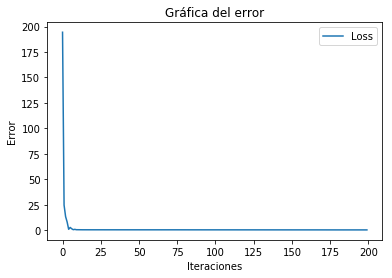

In [50]:
plt.plot(history.history['loss'])
plt.title('Gráfica del error')
plt.ylabel('Error')
plt.xlabel('Iteraciones')
plt.legend(['Loss'], loc='upper right')
plt.show()

# 6 - Pruebas de predicciones cada cierto periodo

### Cargamos el modelo de nuestra red si no estaba cargado de antes

In [54]:
# Cargamos el modelo que nos interesa.
# Modelo entrenado con diez años de datos.
# model = load_model('RedEntrenamiento(2007-2016).h5')

# Modelo entrenado con dos años de datos.
# model = load_model('RedEntrenamiento(2015-2016).h5')

# Modelo entrenado con un año de datos.
model = load_model('RedEntrenamiento(2016).h5')

### Realizamos una predicciones sobre las predicciones hechas con anterioridad, generando dinámicamente nuevos arrays que contengan las predicciones anteriores.

### Función para realizar las predicciones de los diferentes periodos

In [55]:
def predecirPeriodo (inicio, fin, periodo, y):
    
    # Inicializamos un vector a ceros.
    yPeriodo = np.zeros(periodo)
    cont = 0
    
    # Con este for cogemos solo un periodo de las salidas de las cuales predeciremos el siguiente periodo.
    for i in range (inicio, fin):
        yPeriodo[cont] = y[i]
        cont = cont + 1
    
    # Hacemos un reshape necesario para predecir con el modelo LSTM.
    yPeriodo = np.reshape(yPeriodo, (1, 1, periodo))
    
    # Guardamos en prediccionPeriodo los valores de yPeriodo que poco a poco se irán cambiando por los valores predichos.
    prediccionPeriodo = yPeriodo
    datoPredicho = 0
    
    
    for i in range (0, periodo):
    
        # Predecimos 
        datoPredicho = model.predict(prediccionPeriodo)
        # En yPeriodo le metemos el nuevo dato predicho
        yPeriodo = np.append(yPeriodo, datoPredicho)
    
        for j in range(0, periodo):
            prediccionPeriodo[0][0][j] = yPeriodo[i + j + 1]
    
    
    # Tenemos que hacer un reshape para poder luego usarlo en la gráfica.
    prediccionPeriodo = np.reshape(prediccionPeriodo, (periodo))
    
    
    cont=0
    diasPrediccion = np.zeros((periodo))
    for i in range (inicio, fin):
        diasPrediccion[cont] = i
        cont = cont + 1
    

    
    return diasPrediccion, prediccionPeriodo

### Cargamos el archivo con el cual queremos predecir

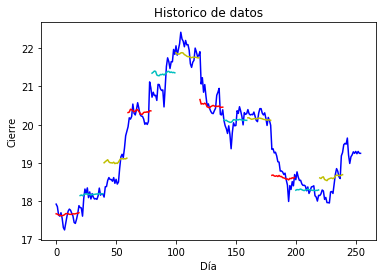

In [56]:
# Cargamos los datos.
DatosPrediccion = pd.read_csv('GAS.MC.Prediccion(2017).csv')

# Guardamos los datos de los precios de cierre en una variable
y = DatosPrediccion['Close']
# Pasamos el dataset a tipo float.
y = y.astype(float)
# Transformamos el dataset a un vector array.
y = np.array(y)

# Vamos a predecir para probar con doce periodos para obtener las predicciones de todo el año.
# Aqui es donde realizaremos las llamadas a la función que creamos antes.
# Primer periodo
inicio = 0
fin = periodo
diasPrediccion1, yPrediccion1 = predecirPeriodo (inicio, fin, periodo, y)
# Segundo periodo
inicio = periodo
fin = periodo * 2
diasPrediccion2, yPrediccion2 = predecirPeriodo (inicio, fin, periodo, y)
# Tercer periodo
inicio = periodo * 2
fin = periodo * 3
diasPrediccion3, yPrediccion3 = predecirPeriodo (inicio, fin, periodo, y)
# Cuarto periodo
inicio = periodo * 3
fin = periodo * 4
diasPrediccion4, yPrediccion4 = predecirPeriodo (inicio, fin, periodo, y)
# Quinto periodo
inicio = periodo * 4
fin = periodo * 5
diasPrediccion5, yPrediccion5 = predecirPeriodo (inicio, fin, periodo, y)
# Sexto periodo
inicio = periodo * 5
fin = periodo * 6
diasPrediccion6, yPrediccion6 = predecirPeriodo (inicio, fin, periodo, y)
# Septima periodo
inicio = periodo * 6
fin = periodo * 7
diasPrediccion7, yPrediccion7 = predecirPeriodo (inicio, fin, periodo, y)
# Octavo periodo
inicio = periodo * 7
fin = periodo * 8
diasPrediccion8, yPrediccion8 = predecirPeriodo (inicio, fin, periodo, y)
# Noveno periodo
inicio = periodo * 8
fin = periodo * 9
diasPrediccion9, yPrediccion9 = predecirPeriodo (inicio, fin, periodo, y)
# Decimo periodo
inicio = periodo * 9
fin = periodo * 10
diasPrediccion10, yPrediccion10 = predecirPeriodo (inicio, fin, periodo, y)
# Onceavo periodo
inicio = periodo * 10
fin = periodo * 11
diasPrediccion11, yPrediccion11 = predecirPeriodo (inicio, fin, periodo, y)
# Doceavo periodo
inicio = periodo * 11
fin = periodo * 12
diasPrediccion12, yPrediccion12 = predecirPeriodo (inicio, fin, periodo, y)


# Para la gráfica 
Dias = len(y)
NumDia = np.zeros((len(y)))
SalidaGrafica = np.zeros((Dias))
cont = 0
for i in range (0, len(y)):
    SalidaGrafica[cont] = y[i]
    cont = cont +1
    
#print(SalidaGrafica)

for i in range(0, len(SalidaGrafica)):
    NumDia[i] = i

plt.clf()
plt.plot(NumDia,SalidaGrafica, 'b')
plt.plot(diasPrediccion1, yPrediccion1, 'r')
plt.plot(diasPrediccion2, yPrediccion2, 'c')
plt.plot(diasPrediccion3, yPrediccion3, 'y')
plt.plot(diasPrediccion4, yPrediccion4, 'r')
plt.plot(diasPrediccion5, yPrediccion5, 'c')
plt.plot(diasPrediccion6, yPrediccion6, 'y')
plt.plot(diasPrediccion7, yPrediccion7, 'r')
plt.plot(diasPrediccion8, yPrediccion8, 'c')
plt.plot(diasPrediccion9, yPrediccion9, 'y')
plt.plot(diasPrediccion10, yPrediccion10, 'r')
plt.plot(diasPrediccion11, yPrediccion11, 'c')
plt.plot(diasPrediccion12, yPrediccion12, 'y')

plt.xlabel('Día')
plt.ylabel('Cierre')
plt.title('Historico de datos')
plt.show()


# 7 - Calculamos el valor de los pesos de cada parámetro de nuestro dataset

In [57]:
for i in range(0, periodo):
    print("Para la entrada", i, "la suma de sus pesos es:", sum((model.get_weights()[0][i])**2))

Para la entrada 0 la suma de sus pesos es: 1.947409453738672
Para la entrada 1 la suma de sus pesos es: 1.9633955664471796
Para la entrada 2 la suma de sus pesos es: 1.849252471864884
Para la entrada 3 la suma de sus pesos es: 1.92762944596843
Para la entrada 4 la suma de sus pesos es: 2.0349128994484666
Para la entrada 5 la suma de sus pesos es: 1.9584287682718937
Para la entrada 6 la suma de sus pesos es: 1.8870672862909332
Para la entrada 7 la suma de sus pesos es: 1.8983033322593057
Para la entrada 8 la suma de sus pesos es: 1.913709916733496
Para la entrada 9 la suma de sus pesos es: 1.9859710174139908
Para la entrada 10 la suma de sus pesos es: 1.9062351342723352
Para la entrada 11 la suma de sus pesos es: 2.002986954094112
Para la entrada 12 la suma de sus pesos es: 1.8798267347773
Para la entrada 13 la suma de sus pesos es: 2.0091275872666543
Para la entrada 14 la suma de sus pesos es: 2.0457864701811914
Para la entrada 15 la suma de sus pesos es: 2.0632582719836154
Para la ent